#### Implémentation d'un réseau de neurones (version vanilla utilisant torch tensors)

Importer les libraries nécessaires

In [13]:
import matplotlib.pyplot as plt
plt.ion()
import torch
import numpy as np
import scipy.io

Ecrire la fonction ``init_params(nx, nh, ny)`` qui initialise les poids d’un réseau à partir des tailles
$n_x$, $n_h$ et $n_y$ et les stocke dans un dictionnaire. Tous les poids seront initialisés selon une loi normale de moyenne $0$ et d’écart-type $0.3$.

In [14]:
def init_params(nx, nh, ny):
    """
    Cette fonction initialise les poids d’un réseau à partir des tailles n_x, n_h et n_y 
    et les stocke dans un dictionnaire. Tous les poids seront initialisés selon une loi normale 
    de moyenne 0 et d’écart-type 0.3.
    """
    w_h = torch.randn(nh, nx) * 0.3
    w_y = torch.randn(ny, nh) * 0.3

    b_h = torch.zeros(nh, 1)
    b_y = torch.zeros(ny, 1)
    
    params = {
        "w_h": w_h,
        "b_h": b_h,
        "w_y": w_y,
        "b_y": b_y
    }
    
    return params

init_params(2, 4, 2)

{'w_h': tensor([[-0.6303,  0.5717],
         [-0.2103,  0.0768],
         [-0.2821,  0.4046],
         [ 0.3984, -0.2662]]),
 'b_h': tensor([[0.],
         [0.],
         [0.],
         [0.]]),
 'w_y': tensor([[-0.4137, -0.2057, -0.5389,  0.1712],
         [ 0.1300,  0.0923,  0.2434, -0.0024]]),
 'b_y': tensor([[0.],
         [0.]])}

Ecrire la fonction ``forward(params, X)`` qui calcule les étapes intermédiaires et la sortie du réseau
à partir d’un batch d’entrée $X$ de taille $ n_{\text{batch}} \times n_{\text{x}} $ et des poids stockés dans ``params`` et les stocke dans un dictionnaire. On retourne le dictionnaire des étapes intermédiaires et la sortie $\hat Y$ du réseau.

In [15]:
def forward(params, X):
    """
    Effectue un forward pass à travers le réseau.

    Arguments:
    - params: un dictionnaire contenant les poids et les biais du réseau
    - X: un batch d'entrée de taille n_batch * n_x

    Retourne:
    - outputs['y_hat']: la sortie du réseau
    - outputs: un dictionnaire contenant les sorties intermédiaires et les activations
    """
    
    h_tilde = torch.mm(X, params["w_h"].t()) + params["b_h"].t()
    h = torch.tanh(h_tilde)
    y_tilde = torch.mm(h, params["w_y"].t()) + params["b_y"].t()
    exp_y = torch.exp(y_tilde - y_tilde.max(dim=1, keepdim=True)[0])
    y_hat = exp_y / exp_y.sum(dim=1, keepdim=True)
    # y_hat = torch.softmax(y_tilde, dim=1)
    
    outputs = {
        "X": X,
        "h_tilde": h_tilde,
        "h" : h,
        "y_tilde" : y_tilde,
        "y_hat" : y_hat,
    }
    
    return outputs['y_hat'], outputs

Tester le forward pass

In [16]:
X = torch.randn(10, 2)
params = init_params(2, 4, 2)
y_hat, intermediate_outputs = forward(params, X)
print("Input X:", X)
print("Output y_hat:", y_hat)
print("Intermediate outputs:", intermediate_outputs)

Input X: tensor([[-1.5779,  0.3878],
        [-1.5256,  1.5746],
        [ 0.9772,  0.2983],
        [ 1.0278, -0.6413],
        [ 0.4983, -0.9912],
        [-0.2176,  0.0996],
        [-0.7804, -0.3577],
        [ 0.1261,  0.4435],
        [-0.8740, -1.4108],
        [-2.5102, -1.6254]])
Output y_hat: tensor([[0.4545, 0.5455],
        [0.4207, 0.5793],
        [0.5191, 0.4809],
        [0.5465, 0.4535],
        [0.5434, 0.4566],
        [0.4901, 0.5099],
        [0.4868, 0.5132],
        [0.4919, 0.5081],
        [0.5129, 0.4871],
        [0.5111, 0.4889]])
Intermediate outputs: {'X': tensor([[-1.5779,  0.3878],
        [-1.5256,  1.5746],
        [ 0.9772,  0.2983],
        [ 1.0278, -0.6413],
        [ 0.4983, -0.9912],
        [-0.2176,  0.0996],
        [-0.7804, -0.3577],
        [ 0.1261,  0.4435],
        [-0.8740, -1.4108],
        [-2.5102, -1.6254]]), 'h_tilde': tensor([[ 0.8046, -0.2148,  0.8153,  0.0958],
        [ 0.7419, -0.0829,  0.7462, -0.1056],
        [-0.5145,  0.1

Ecrire la fonction ``loss_accuracy(y_hat, y)`` qui calcule la fonction de coût et la précision (taux de bonnes prédictions) à partir d’une matrice de sortie $ \hat Y $ (sortie de forward ) vis-à-vis d’une matrice de vérité terrain $Y$ de même taille, et retourne la loss $L$ et la précision ``acc``.

Note : On utilisera la fonction ``_, indsY = torch.max(Y, 1)`` qui retourne l’indice de la classe
prédite (ou à prédire) pour chaque exemple.

In [17]:
def loss_accuracy(y_hat, y):
    """
    Calcule la loss d'entropie croisée et la précision.

    Arguments:
    - y_hat: les prédictions du réseau, de taille n_batch * n_y
    - y: la vérité terrain, de taille n_batch * n_y

    Retourne:
    - L: la loss (entropie croisée)
    - acc: la précision (taux de bonnes prédictions)
    """
    
    epsilon = 1e-8
    
    _, indsY = torch.max(y, 1)
    
    L = -torch.sum(y * torch.log(y_hat + epsilon)) / y.size(0)
    # L = F.cross_entropy(y_hat, indsY)
    
    _, indsy_hat = torch.max(y_hat, 1)

    acc = torch.sum(indsy_hat == indsY).float() / y.size(0)

    return L, acc

Tester la loss

In [18]:
y = torch.tensor([[0, 1]])
y = y.expand_as(y_hat)
assert y_hat.size(0) == y.size(0)
L, acc = loss_accuracy(y_hat, y)
print("Loss:", L.item())
print("Accuracy:", acc.item())

Loss: 0.6911188960075378
Accuracy: 0.5


Ecrire la fonction ``backward(params, outputs, Y)`` qui calcule les gradients de la loss par rapport
aux paramètres et les stocke dans un dictionnaire.

In [19]:
def backward(params, outputs, y):
    """
    Calcule les gradients de la loss par rapport aux paramètres.
    
    Arguments:
    - params : un dictionnaire contenant les poids et les biais du réseau
    - outputs : un dictionnaire contenant les sorties intermédiaires et les activations
    - y : les vraies valeurs à prédire
    
    Retourne:
    - grads : un dictionnaire des gradients calculés
    """
    m = y.shape[0]
    
    dy_hat = (outputs["y_hat"] - y) * (1 - outputs["y_hat"]**2)
    
    # couche de sortie
    dw_y = torch.mm(dy_hat.t(), outputs["h"]) / m
    db_y = torch.sum(dy_hat, axis=0, keepdim=True) / m
    
    # couche cachée
    dh = torch.mm(dy_hat, params["w_y"]) * (1 - outputs["h"]**2)
    dw_h = torch.mm(dh.t(), outputs["X"]) / m
    db_h = torch.sum(dh, axis=0, keepdim=True) / m
    
    grads = {
        "w_y": dw_y,
        "b_y": db_y,
        "w_h": dw_h,
        "b_h": db_h
    }
    
    return grads

Tester le backward pass

In [20]:
grads = backward(params, intermediate_outputs, y)

print("Gradients:")
for key, value in grads.items():
    print(f"{key}: {value}")

Gradients:
w_y: tensor([[ 0.0672, -0.0351,  0.0680,  0.0306],
        [-0.0569,  0.0337, -0.0576, -0.0320]])
b_y: tensor([[ 0.3725, -0.3728]])
w_h: tensor([[ 0.0193,  0.0147],
        [ 0.0692,  0.0466],
        [ 0.0043,  0.0191],
        [-0.0537, -0.0406]])
b_h: tensor([[-0.0820, -0.1919, -0.0604,  0.1538]])


Ecrire la fonction ``sgd(params, grads, eta)`` qui applique une descente de gradient stochastique par
mini-batch et met à jour les paramètres du réseau à partir de leurs gradients et du pas d’apprentissage.

In [21]:
def sgd(params, grads, eta):
    
    """
    Cette fonction applique une descente de gradient stochastique par mini-batch et met à jour 
    les paramètres du réseau à partir de leurs gradients et du pas d’apprentissage.
    
    Retourne: les paramètres après mise à jour.
    """
    params["w_h"] -= eta * grads["w_h"]
    params["b_h"] -= eta * grads["b_h"].reshape(-1, 1)
    params["w_y"] -= eta * grads["w_y"]
    params["b_y"] -= eta * grads["b_y"].reshape(-1, 1)
    
    return params

Tester la descente de gradient stochastique

In [22]:
step = 0.05
params_updated = sgd(params, grads, step)
for key, value in params_updated.items():
    print(f"{key}: {value}")

w_h: tensor([[-0.5183, -0.0308],
        [ 0.1583,  0.1017],
        [-0.5256, -0.0360],
        [-0.0986, -0.1632]])
b_h: tensor([[ 0.0041],
        [ 0.0096],
        [ 0.0030],
        [-0.0077]])
w_y: tensor([[-0.3580, -0.1646,  0.2920, -0.0080],
        [-0.0590,  0.3729,  0.5110, -0.4354]])
b_y: tensor([[-0.0186],
        [ 0.0186]])


Charger et préparer les données

In [23]:
class CirclesData:

    def __init__(self):
        # Grid
        x1,x2 = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
        self._Xgrid = np.array([x1.flatten(), x2.flatten()]).T.astype('float32')

        # Real data
        circles = scipy.io.loadmat("../resources/data/circles.mat")
        self._Xtrain, self._Xtest, self._Ytrain, self._Ytest = circles["Xtrain"].astype('float32'), circles["Xtest"].astype('float32'), circles["Ytrain"].astype('float32'), circles["Ytest"].astype('float32')

        self._Xgrid_th = torch.from_numpy(self._Xgrid)
        self._Xtrain_th = torch.from_numpy(self._Xtrain)
        self._Xtest_th = torch.from_numpy(self._Xtest)
        self._Ytrain_th = torch.from_numpy(self._Ytrain)
        self._Ytest_th = torch.from_numpy(self._Ytest)

        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []

    def __getattr__(self, key):
        if key == "Xgrid": return self._Xgrid_th
        if key == "Xtrain": return self._Xtrain_th
        if key == "Xtest": return self._Xtest_th
        if key == "Ytrain": return self._Ytrain_th
        if key == "Ytest": return self._Ytest_th
        return None

    def plot_data(self):
        plt.figure(1, figsize=(5,5))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0], self._Xtrain[self._Ytrain[:,0] == 1,1], 'bo', label="Train")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0], self._Xtrain[self._Ytrain[:,1] == 1,1], 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0], self._Xtest[self._Ytest[:,0] == 1,1], 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0], self._Xtest[self._Ytest[:,1] == 1,1], 'r+')
        plt.legend()
        plt.show()

    def plot_data_with_grid(self, Ygrid, title=""):
        plt.figure(2)
        Ygrid = Ygrid[:,1].numpy()
        plt.clf()
        plt.imshow(np.reshape(Ygrid, (40,40)))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Training")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,1] == 1,1]*10+20, 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0]*10+20, self._Xtest[self._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0]*10+20, self._Xtest[self._Ytest[:,1] == 1,1]*10+20, 'r+')
        plt.xlim(0,39)
        plt.ylim(0,39)
        plt.clim(0.3,0.7)
        plt.title(title)
        plt.draw()
        plt.pause(1e-3)

    def plot_loss(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        plt.figure(3)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.array(self.acc_train), label="Training Accuracy")
        plt.plot(np.array(self.acc_test), label="Test Accuracy")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(self.loss_train), label="Training Loss")
        plt.plot(np.array(self.loss_test), label="Test Loss")
        plt.legend()
        plt.show()

Ecrire l’algorithme global d’apprentissage en utilisant ces fonctions.

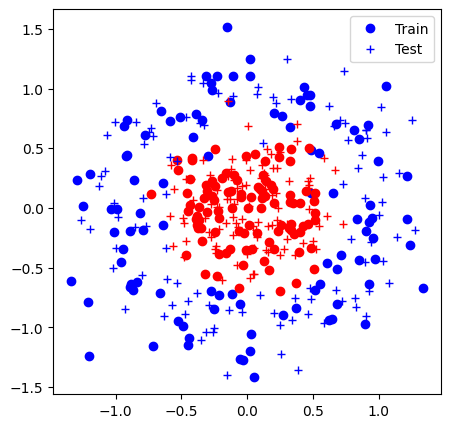

Iter 0: Acc train 0.5% (0.70), acc test 0.5% (0.70)


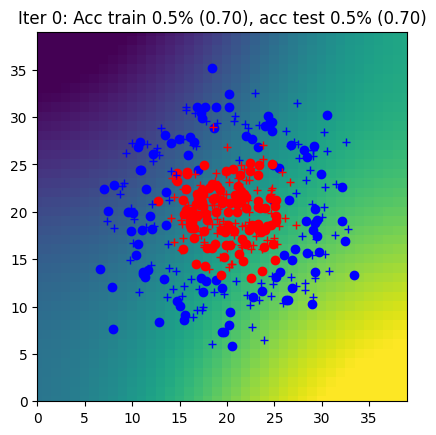

Iter 1: Acc train 0.6% (0.69), acc test 0.6% (0.70)
Iter 2: Acc train 0.6% (0.69), acc test 0.6% (0.70)
Iter 3: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 4: Acc train 0.7% (0.69), acc test 0.6% (0.69)
Iter 5: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 6: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 7: Acc train 0.7% (0.69), acc test 0.7% (0.69)
Iter 8: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 9: Acc train 0.7% (0.69), acc test 0.7% (0.69)
Iter 10: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 11: Acc train 0.6% (0.69), acc test 0.5% (0.69)
Iter 12: Acc train 0.6% (0.69), acc test 0.6% (0.69)
Iter 13: Acc train 0.6% (0.69), acc test 0.7% (0.69)
Iter 14: Acc train 0.7% (0.69), acc test 0.7% (0.69)
Iter 15: Acc train 0.7% (0.69), acc test 0.7% (0.69)
Iter 16: Acc train 0.7% (0.69), acc test 0.7% (0.69)
Iter 17: Acc train 0.7% (0.68), acc test 0.7% (0.69)
Iter 18: Acc train 0.7% (0.68), acc test 0.7% (0.68)
Iter 19: Acc train 0.6% (0.68), acc test 0.6% (0.68)
It

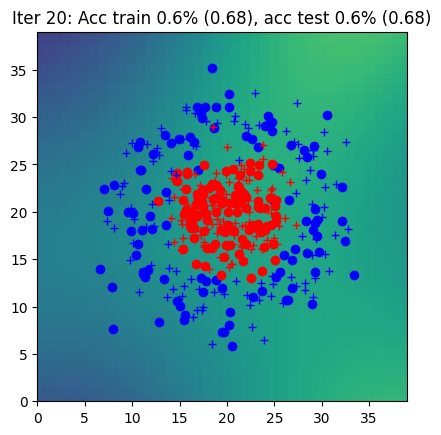

Iter 21: Acc train 0.7% (0.68), acc test 0.7% (0.68)
Iter 22: Acc train 0.7% (0.68), acc test 0.7% (0.68)
Iter 23: Acc train 0.7% (0.68), acc test 0.7% (0.68)
Iter 24: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 25: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 26: Acc train 0.6% (0.68), acc test 0.6% (0.68)
Iter 27: Acc train 0.7% (0.68), acc test 0.7% (0.68)
Iter 28: Acc train 0.7% (0.67), acc test 0.7% (0.67)
Iter 29: Acc train 0.7% (0.67), acc test 0.7% (0.67)
Iter 30: Acc train 0.8% (0.67), acc test 0.8% (0.67)
Iter 31: Acc train 0.7% (0.67), acc test 0.7% (0.67)
Iter 32: Acc train 0.7% (0.67), acc test 0.7% (0.67)
Iter 33: Acc train 0.7% (0.67), acc test 0.6% (0.67)
Iter 34: Acc train 0.7% (0.67), acc test 0.7% (0.67)
Iter 35: Acc train 0.8% (0.66), acc test 0.8% (0.66)
Iter 36: Acc train 0.7% (0.66), acc test 0.7% (0.66)
Iter 37: Acc train 0.8% (0.66), acc test 0.7% (0.66)
Iter 38: Acc train 0.8% (0.66), acc test 0.8% (0.66)
Iter 39: Acc train 0.8% (0.65), acc test 0.8% 

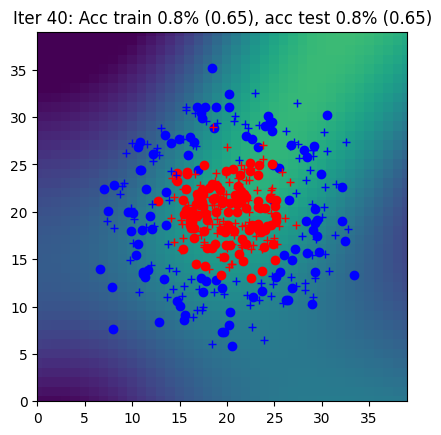

Iter 41: Acc train 0.8% (0.65), acc test 0.8% (0.65)
Iter 42: Acc train 0.8% (0.65), acc test 0.9% (0.64)
Iter 43: Acc train 0.8% (0.64), acc test 0.9% (0.64)
Iter 44: Acc train 0.8% (0.64), acc test 0.8% (0.64)
Iter 45: Acc train 0.8% (0.64), acc test 0.8% (0.63)
Iter 46: Acc train 0.8% (0.63), acc test 0.9% (0.63)
Iter 47: Acc train 0.8% (0.63), acc test 0.8% (0.63)
Iter 48: Acc train 0.8% (0.62), acc test 0.8% (0.62)
Iter 49: Acc train 0.8% (0.62), acc test 0.8% (0.62)
Iter 50: Acc train 0.8% (0.61), acc test 0.9% (0.61)
Iter 51: Acc train 0.8% (0.61), acc test 0.8% (0.61)
Iter 52: Acc train 0.8% (0.61), acc test 0.8% (0.60)
Iter 53: Acc train 0.8% (0.60), acc test 0.8% (0.60)
Iter 54: Acc train 0.8% (0.60), acc test 0.9% (0.59)
Iter 55: Acc train 0.8% (0.59), acc test 0.8% (0.59)
Iter 56: Acc train 0.8% (0.59), acc test 0.8% (0.58)
Iter 57: Acc train 0.8% (0.58), acc test 0.8% (0.58)
Iter 58: Acc train 0.8% (0.57), acc test 0.8% (0.57)
Iter 59: Acc train 0.8% (0.57), acc test 0.8% 

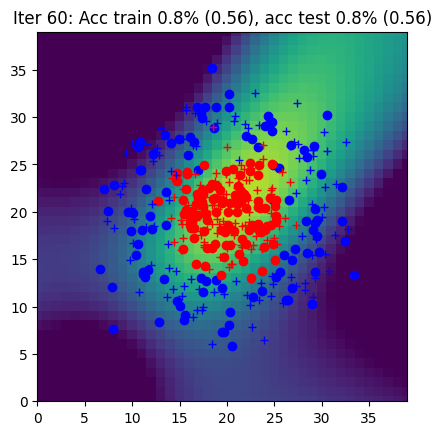

Iter 61: Acc train 0.8% (0.56), acc test 0.8% (0.55)
Iter 62: Acc train 0.8% (0.55), acc test 0.8% (0.55)
Iter 63: Acc train 0.8% (0.54), acc test 0.8% (0.54)
Iter 64: Acc train 0.8% (0.54), acc test 0.8% (0.54)
Iter 65: Acc train 0.8% (0.53), acc test 0.9% (0.53)
Iter 66: Acc train 0.8% (0.53), acc test 0.8% (0.52)
Iter 67: Acc train 0.8% (0.52), acc test 0.8% (0.52)
Iter 68: Acc train 0.8% (0.51), acc test 0.8% (0.51)
Iter 69: Acc train 0.8% (0.51), acc test 0.9% (0.50)
Iter 70: Acc train 0.8% (0.50), acc test 0.8% (0.50)
Iter 71: Acc train 0.9% (0.49), acc test 0.9% (0.49)
Iter 72: Acc train 0.9% (0.49), acc test 0.9% (0.48)
Iter 73: Acc train 0.9% (0.48), acc test 0.9% (0.48)
Iter 74: Acc train 0.9% (0.47), acc test 0.9% (0.47)
Iter 75: Acc train 0.9% (0.46), acc test 0.9% (0.46)
Iter 76: Acc train 0.9% (0.46), acc test 0.9% (0.45)
Iter 77: Acc train 0.9% (0.45), acc test 0.9% (0.45)
Iter 78: Acc train 0.9% (0.44), acc test 0.9% (0.44)
Iter 79: Acc train 0.9% (0.44), acc test 0.9% 

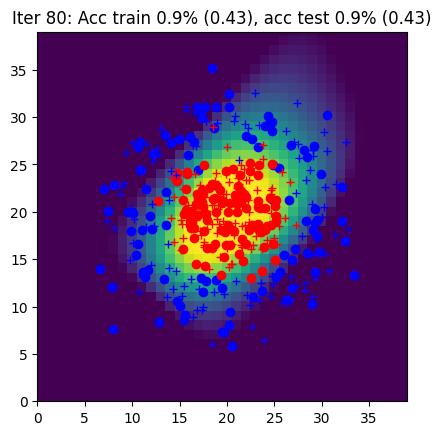

Iter 81: Acc train 0.9% (0.42), acc test 0.9% (0.42)
Iter 82: Acc train 0.9% (0.41), acc test 0.9% (0.41)
Iter 83: Acc train 0.9% (0.41), acc test 1.0% (0.40)
Iter 84: Acc train 0.9% (0.40), acc test 0.9% (0.40)
Iter 85: Acc train 0.9% (0.39), acc test 0.9% (0.39)
Iter 86: Acc train 0.9% (0.39), acc test 0.9% (0.38)
Iter 87: Acc train 0.9% (0.38), acc test 0.9% (0.38)
Iter 88: Acc train 0.9% (0.38), acc test 1.0% (0.37)
Iter 89: Acc train 0.9% (0.37), acc test 1.0% (0.37)
Iter 90: Acc train 0.9% (0.36), acc test 1.0% (0.36)
Iter 91: Acc train 0.9% (0.36), acc test 0.9% (0.35)
Iter 92: Acc train 0.9% (0.35), acc test 0.9% (0.35)
Iter 93: Acc train 0.9% (0.35), acc test 1.0% (0.34)
Iter 94: Acc train 0.9% (0.34), acc test 0.9% (0.34)
Iter 95: Acc train 0.9% (0.34), acc test 0.9% (0.33)
Iter 96: Acc train 0.9% (0.33), acc test 1.0% (0.33)
Iter 97: Acc train 0.9% (0.33), acc test 0.9% (0.33)
Iter 98: Acc train 0.9% (0.33), acc test 0.9% (0.32)
Iter 99: Acc train 0.9% (0.32), acc test 1.0% 

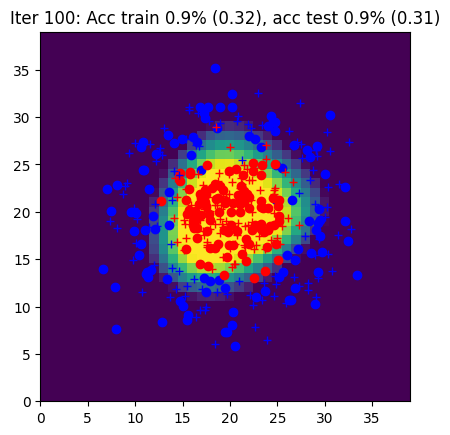

Iter 101: Acc train 0.9% (0.31), acc test 0.9% (0.31)
Iter 102: Acc train 0.9% (0.31), acc test 0.9% (0.31)
Iter 103: Acc train 0.9% (0.31), acc test 0.9% (0.30)
Iter 104: Acc train 0.9% (0.31), acc test 0.9% (0.30)
Iter 105: Acc train 0.9% (0.30), acc test 0.9% (0.30)
Iter 106: Acc train 0.9% (0.30), acc test 0.9% (0.30)
Iter 107: Acc train 0.9% (0.30), acc test 0.9% (0.29)
Iter 108: Acc train 0.9% (0.30), acc test 0.9% (0.29)
Iter 109: Acc train 0.9% (0.30), acc test 0.9% (0.29)
Iter 110: Acc train 0.9% (0.29), acc test 0.9% (0.29)
Iter 111: Acc train 0.9% (0.29), acc test 0.9% (0.29)
Iter 112: Acc train 0.9% (0.29), acc test 0.9% (0.28)
Iter 113: Acc train 0.9% (0.29), acc test 0.9% (0.28)
Iter 114: Acc train 0.9% (0.29), acc test 0.9% (0.28)
Iter 115: Acc train 0.9% (0.29), acc test 0.9% (0.28)
Iter 116: Acc train 0.9% (0.28), acc test 0.9% (0.28)
Iter 117: Acc train 0.9% (0.28), acc test 0.9% (0.28)
Iter 118: Acc train 0.9% (0.28), acc test 0.9% (0.28)
Iter 119: Acc train 0.9% (0.

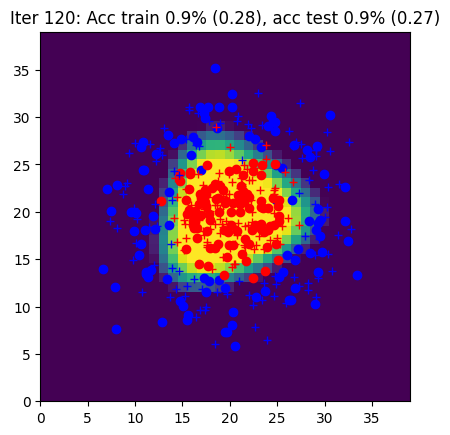

Iter 121: Acc train 0.9% (0.28), acc test 0.9% (0.27)
Iter 122: Acc train 0.9% (0.28), acc test 0.9% (0.27)
Iter 123: Acc train 0.9% (0.28), acc test 0.9% (0.27)
Iter 124: Acc train 0.9% (0.27), acc test 0.9% (0.27)
Iter 125: Acc train 0.9% (0.27), acc test 0.9% (0.27)
Iter 126: Acc train 0.9% (0.27), acc test 0.9% (0.27)
Iter 127: Acc train 0.9% (0.27), acc test 0.9% (0.27)
Iter 128: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 129: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 130: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 131: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 132: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 133: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 134: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 135: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 136: Acc train 0.9% (0.26), acc test 0.9% (0.26)
Iter 137: Acc train 0.9% (0.27), acc test 0.9% (0.26)
Iter 138: Acc train 0.9% (0.26), acc test 0.9% (0.26)
Iter 139: Acc train 0.9% (0.

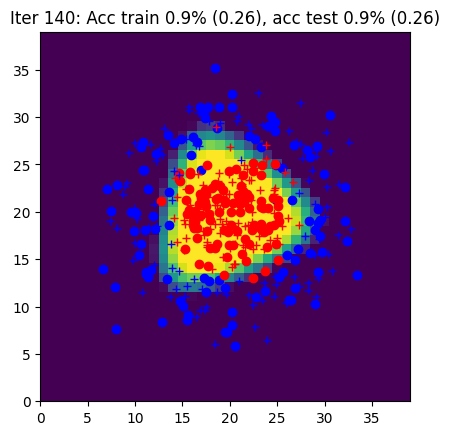

Iter 141: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 142: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 143: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 144: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 145: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 146: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 147: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 148: Acc train 0.9% (0.26), acc test 0.9% (0.25)
Iter 149: Acc train 0.9% (0.26), acc test 0.9% (0.25)


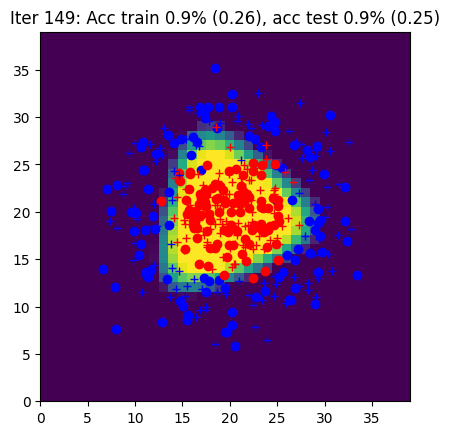

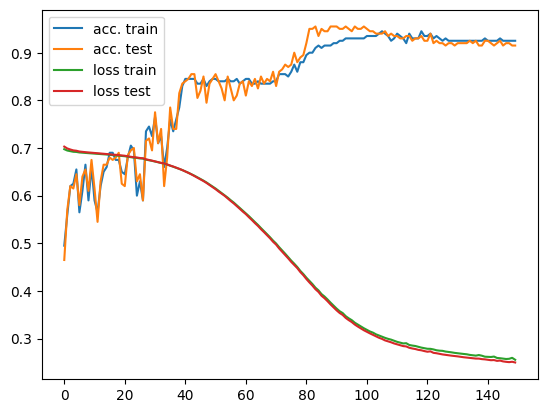

In [24]:
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.05
iter = 150

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

for i in range(iter):

    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(i, acctrain, Ltrain, acctest, Ltest)
    print(title)
    if i % 20 == 0 or i == iter - 1:
        data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()